In [191]:
import itertools
import math
import os

import gsd.hoomd
import hoomd
import numpy

In [192]:
N_particles = 108
rho = 0.8442
T = 0.728
box_volume = N_particles/rho
L = box_volume**(1/3)
spacing = L / math.ceil(N_particles ** (1/3))

x = numpy.linspace(-L / 2, L / 2, math.ceil(N_particles ** (1/3)), endpoint=False)
position = list(itertools.product(x, repeat=3))

In [ ]:
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, L, 0, 0, 0]

In [194]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if (
        "version" not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return IPython.display.Image(tracer.sample(scene, samples=samples)._repr_png_())

In [1]:
frame.particles.types = ["A"]

NameError: name 'frame' is not defined

In [196]:
if os.path.exists("lattice.gsd"):
    os.remove("lattice.gsd")

# Now open and write to the file
with gsd.hoomd.open(name="lattice.gsd", mode="x") as f:
    f.append(frame)

In [197]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename="lattice.gsd")

In [198]:
# Create the integrator
integrator = hoomd.md.Integrator(dt=0.005)

# Set up the neighbor list
cell = hoomd.md.nlist.Cell(buffer=0.2)  # cell system to find neighbours efficiently

# Set up Lennard-Jones potential
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[("A", "A")] = dict(epsilon=1, sigma=1)
lj.r_cut[("A", "A")] = 2.0

# Add the force to the integrator
integrator.forces.append(lj)

# Create an NVE method (ConstantVolume with no thermostat)
nve = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All(), thermostat=None)

# Add the NVE method to the integrator
integrator.methods.append(nve)

# Assign the integrator to the simulation
simulation.operations.integrator = integrator


In [199]:
simulation.operations.integrator = integrator


In [200]:
# currently the velocities are 0
snapshot = simulation.state.get_snapshot()
snapshot.particles.velocity[0:5]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [201]:
#assign nonzero correct velocities
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=T)

In [202]:
snapshot = simulation.state.get_snapshot()
snapshot.particles.velocity[0:5]

array([[ 1.36826389,  0.19574028,  0.32760179],
       [-0.10170396, -0.54495446,  0.41844471],
       [ 0.81154921, -1.08313384,  0.54682705],
       [-1.462869  , -2.05022502,  0.98308738],
       [-1.29548127,  1.22201208,  1.00984878]])

In [211]:
# First, set up the thermodynamic properties compute
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)
simulation.operations.computes.append(thermodynamic_properties)

# Create a custom action class to log energy
class EnergyLogger(hoomd.custom.Action):
    def __init__(self, filename):
        super().__init__()
        # Create the log file with a header
        with open(filename, "w") as f:
            f.write("timestep kinetic_energy potential_energy total_energy\n")
        self.filename = filename
        
    def act(self, timestep):
        # Access the energy values directly from thermodynamic_properties
        ke = self.thermodynamic_properties.kinetic_energy
        pe = self.thermodynamic_properties.potential_energy
        total = ke + pe
        
        # Write to the log file
        with open(self.filename, "a") as f:
            f.write(f"{timestep} {ke} {pe} {total}\n")
    
    def attach(self, simulation):
        # Call the parent attach method to set self._state
        super().attach(simulation)
        # Get a reference to the thermodynamic properties
        self.thermodynamic_properties = None
        for compute in simulation.operations.computes:
            if isinstance(compute, hoomd.md.compute.ThermodynamicQuantities):
                self.thermodynamic_properties = compute
                break

# Create the energy logger
energy_logger = EnergyLogger(filename="energy_log.txt")

# Create a custom writer with the energy logger
energy_writer = hoomd.write.CustomWriter(
    action=energy_logger,
    trigger=hoomd.trigger.Periodic(period=10)  # Log every 100 timesteps
)

# Add the writer to the simulation
simulation.operations.writers.append(energy_writer)

In [210]:
#finally we run
simulation.run(2500)

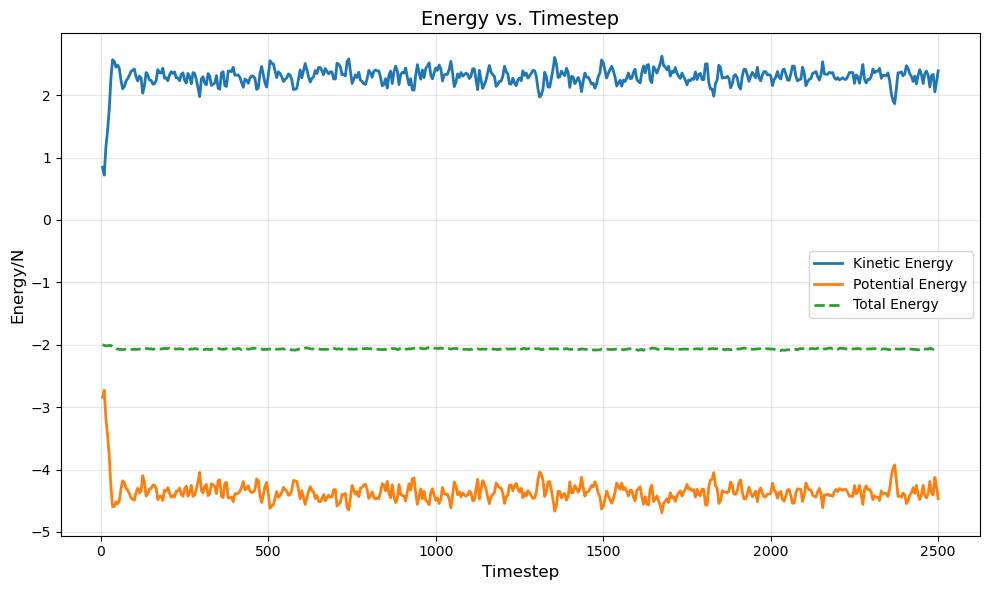

In [207]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the log file
data = np.loadtxt("energy_log.txt", skiprows=1)  # Skip the header row

# Extract columns
timesteps = data[:, 0]
kinetic_energy = data[:, 1]/N_particles
potential_energy = data[:, 2]/N_particles
total_energy = data[:, 3]/N_particles  # Already calculated in our logger

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the energies
plt.plot(timesteps, kinetic_energy, label='Kinetic Energy', linewidth=2)
plt.plot(timesteps, potential_energy, label='Potential Energy', linewidth=2)
plt.plot(timesteps, total_energy, label='Total Energy', linewidth=2, linestyle='--')

# Add labels and title
plt.xlabel('Timestep', fontsize=12)
plt.ylabel('Energy/N', fontsize=12)
plt.title('Energy vs. Timestep', fontsize=14)

# Add a grid and legend
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Improve appearance
plt.tight_layout()

# Save the figure
plt.savefig('energy_plot.png', dpi=300)

# Show the plot
plt.show()

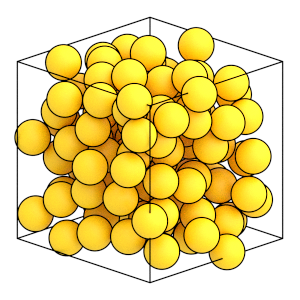

In [208]:
render(simulation.state.get_snapshot())